# Elastic Net Regression with Coordinate Descent and Cross-Validation

Implemented an **elastic net regression model** to predict **credit card balance** from nine demographic and financial features using **coordinate descent** for parameter optimization.  
This project combined the **ridge (L2)** and **lasso (L1)** penalties to enable **simultaneous parameter shrinkage and feature selection**, with **tuning parameters (λ, α)** selected via **five-fold cross-validation**.

Key aspects of the project included:  
- **Coordinate descent implementation** to handle the non-differentiable L1 penalty efficiently.  
- **Feature preprocessing** with centering and standardization for numerical stability.  
- **Systematic exploration of λ (regularization strength) and α (mixing parameter)** across a log-scaled parameter grid.  
- **Visualization of coefficient paths** across λ for multiple α values to demonstrate the effect of combined L1/L2 regularization.  
- **Hyperparameter tuning with five-fold cross-validation**, identifying the optimal λ-α pair that minimized validation error.  
- **Model evaluation and comparison** with **ridge regression (α = 1)** and **lasso (α = 0)** to highlight the trade-off between **bias, variance, and sparsity**.  

This project demonstrates expertise in **regularized regression, feature selection, hyperparameter tuning, and model evaluation**, with direct applications in **credit risk modeling and predictive analytics**.

**Keywords:**  
**elastic net regression**, **coordinate descent**, **feature selection**, **regularization (L1 & L2)**, **hyperparameter tuning**, **cross-validation**, **coefficient path visualization**, **bias-variance trade-off**, **predictive modeling**


# Data Prep

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# set a random seed for reproducibility
np.random.seed(17)

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# path to connect to data
data = '/content/gdrive/My Drive/Credit_N400_p9.csv'
print(os.path.exists(data))

True


In [ ]:
# read the CSV
df = pd.read_csv(data, skipinitialspace=True) # note: we 'skipinitialspace=True' due to issues with white space when creating the design matrix
print(df.shape)
df.head()

(400, 10)


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331


In [ ]:
# map binary categorical data to 0s and 1s with binary encoding
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Student'] = df['Student'].map({'Yes': 1, 'No': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})

df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,1,0,1,333
1,106.025,6645,483,3,82,15,0,1,1,903
2,104.593,7075,514,4,71,11,1,0,0,580
3,148.924,9504,681,3,36,11,0,0,0,964
4,55.882,4897,357,2,68,16,1,0,1,331


# Algorithm 1 Implementation

In [ ]:
# generate N-dimensional response vector
y = df["Balance"].values

# center data
y_mean = np.mean(y)
y = y - y_mean
y = y.reshape(-1, 1)

print(y.shape)

(400, 1)


In [ ]:
# create the design matrix
X = df[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender', 'Student','Married']]

# center and scale the data
X = ((X - X.mean()) / X.std()).to_numpy()

# get observations and features
N = X.shape[0]
p = X.shape[1]

print(X.shape)

(400, 9)


In [ ]:
# check the standardizing
means = X.mean(axis=0)
variances = X.var(axis=0)

print("Means: ", np.round(means, 2))
print("\nVariances: ", np.round(variances, 2))

Means:  [-0. -0.  0. -0.  0.  0.  0.  0. -0.]

Variances:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# precompute b_k (sum of squared values for each feature)
b_k = np.sum(X**2, axis=0)

In [ ]:
# randomly initalize parameter vector beta with values from 0-1
beta = np.random.uniform(-1, 1, size = (p, ))

In [ ]:
# define the elastic net function according to algorithm 1
def elasticNet(X, y, b_k, beta, lambd, alpha, iterations=1000, tol=1e-6):

  for i in range(iterations):
    beta_old = beta.copy()

    # update coefficients
    for k in range(X.shape[1]):
      X_k = X[:, k]  # select the kth feature column

      # calculate resiudal and a_k
      residual = y.flatten() - np.dot(X, beta) + X_k * beta[k]
      a_k = np.dot(X_k.T, residual)

      # update beta_k with scalar a_k
      beta[k] = np.sign(a_k) * np.maximum(abs(a_k) - lambd * (1 - alpha) / 2, 0) / (b_k[k] + lambd * alpha)

      # check for convergence (when beta is unchanging)
      if np.linalg.norm(beta - beta_old, ord=2) < tol:
        break

  return beta  # return final beta


# Deliverable 1

In [ ]:
# define range of lambda values (log-spaced)
lambdas = [10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]

# define range of alpha values
alphas = [0, 1/5, 2/5, 3/5, 4/5, 1]

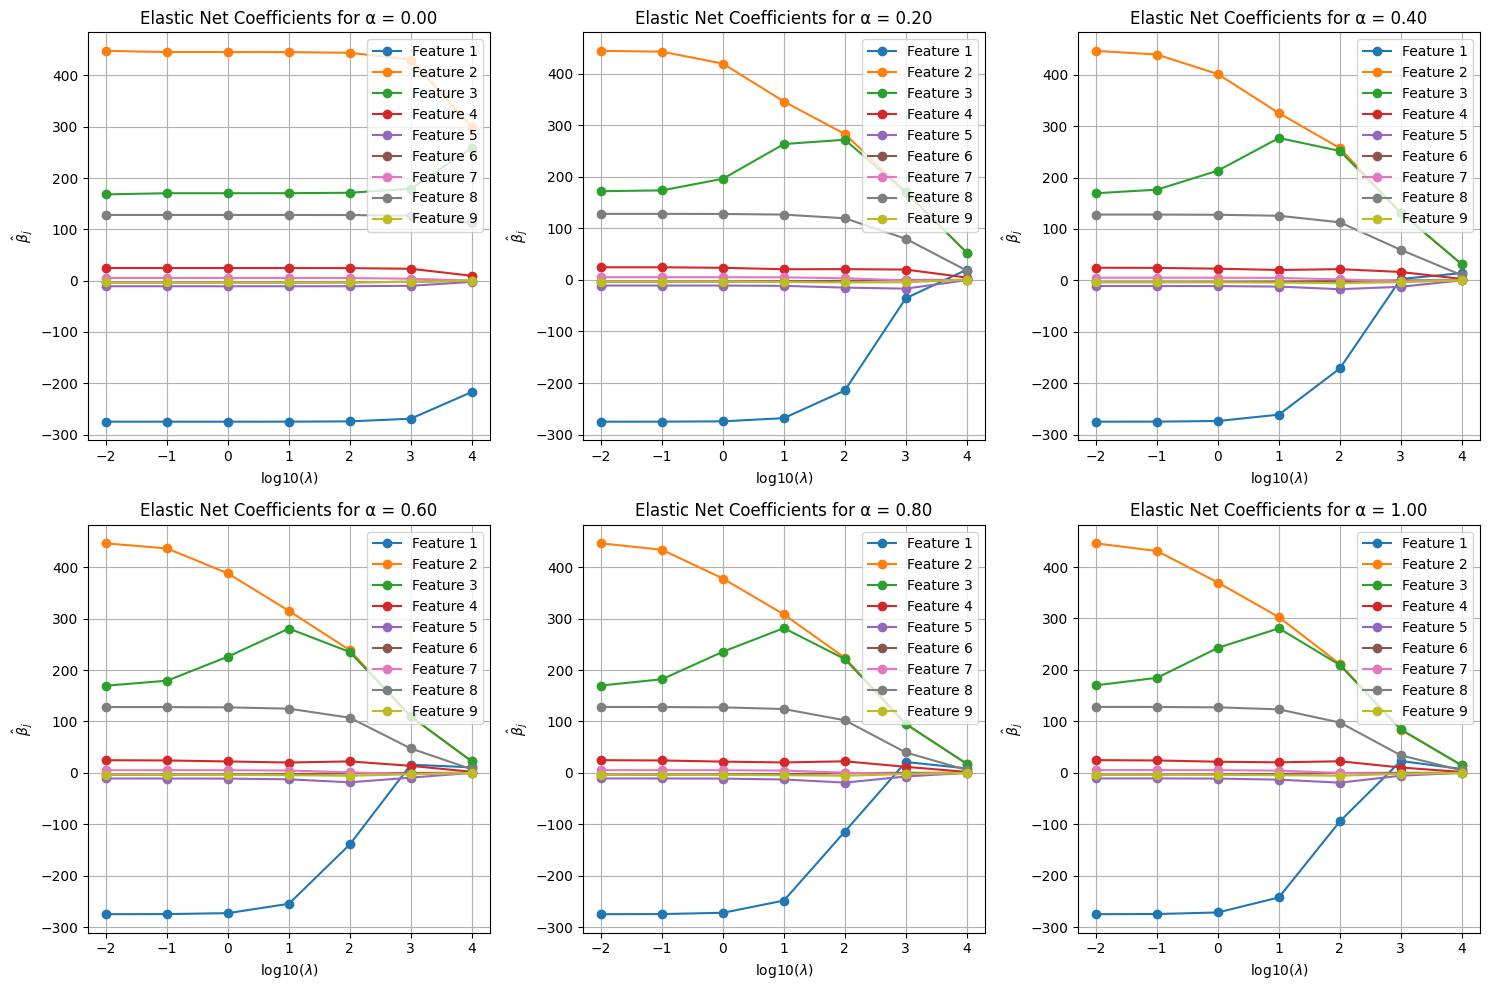

In [ ]:
# initialize coefficients array
coefficients = np.zeros((len(alphas), len(lambdas), p))

# find predictions for each combination of alpha and lambda
for i, alpha in enumerate(alphas):
    for j, lambd in enumerate(lambdas):
        beta_hat = elasticNet(X, y, b_k, beta, lambd, alpha)
        # print(F'Beta with a = {alpha} and l = {lambd}: {beta_hat}') # check output of each combination's predicted coefficients
        coefficients[i, j, :] = beta_hat.flatten()  # store coefficients

# plotting
plt.figure(figsize=(15, 10))
for i, alpha in enumerate(alphas):
    plt.subplot(2, 3, i + 1)

    for feature_idx in range(p):
        plt.plot(np.log10(lambdas), coefficients[i, :, feature_idx], marker='o', label=f'Feature {feature_idx + 1}')
    plt.title(f'Elastic Net Coefficients for α = {alpha:.2f}')
    plt.xlabel(r'log10($\lambda$)') # raw string for LaTeX printing lambda symbol
    plt.ylabel(r'$\hat{\beta}_j$')
    plt.grid(True)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Deliverable 2

In [ ]:
# k-fold (5) cross validation function

def cross_validation(X, y, alpha, lambd, iterations=1000, k_folds=5):

    # split data into k folds
    N = X.shape[0]
    shuffled_indices = np.random.permutation(N)  # shuffle data indices (random seed set to 17 above)
    folds = np.array_split(shuffled_indices, k_folds)

    # store errors
    errors = []

    # iterate over each fold
    for i in range(k_folds):
        # get training and validation data
        test_idx = folds[i] # hold 1 fold for validation
        train_idx = np.concatenate([folds[j] for j in range(k_folds) if j != i]) # other 4 folds for training

        # index training and testing
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # standardize data
        X_train = (X_train - X_train.mean()) / X_train.std()
        X_test = (X_test - X_train.mean()) / X_train.std()

        # call elastic net on training set
        beta_hat = elasticNet(X_train, y_train, b_k, beta, lambd, alpha)

        # predict on validation set
        y_pred = np.dot(X_test, beta_hat)

        # calculate mean squared error (MSE) on validation set
        error = np.mean((y_test - y_pred) ** 2)
        errors.append(error)

    # return average error across the k folds
    return np.mean(errors)


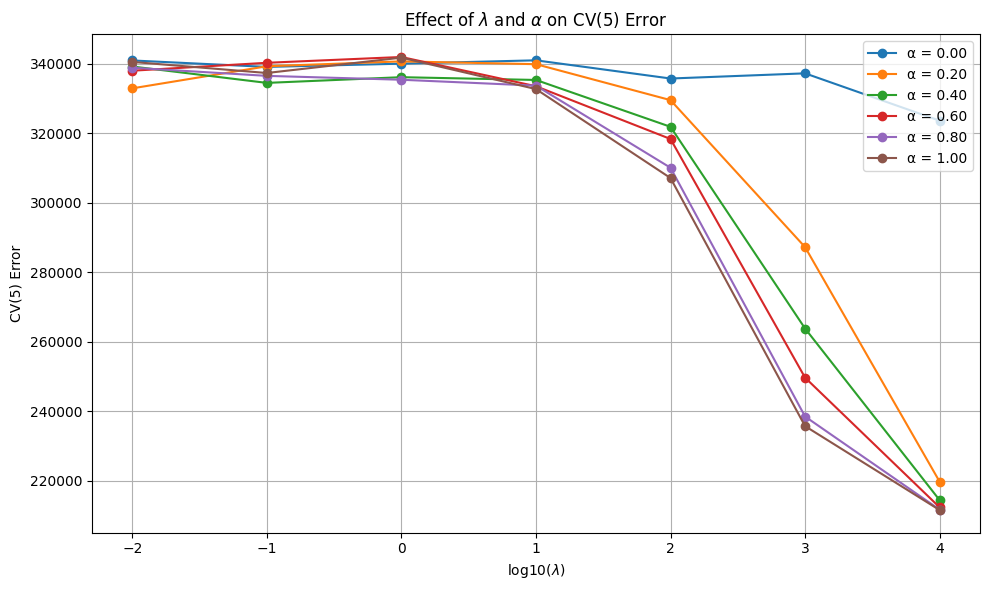

In [ ]:
# initialize CV error array with 6 rows for alpha and 7 columns for lambda
cv_errors = np.zeros((len(alphas), len(lambdas)))

# find predictions for each combination of alpha and lambda
for i, alpha in enumerate(alphas):
  for j, lambd in enumerate(lambdas):
    cv_error = cross_validation(X, y, alpha, lambd)
    cv_errors[i, j] = cv_error


# plot the results
plt.figure(figsize=(10, 6))
log_lambdas = np.log10(lambdas)  # Log scale for lambda
for i, alpha in enumerate(alphas):
    plt.plot(log_lambdas, cv_errors[i, :], marker='o', label=f'α = {alpha:.2f}')

# plot formatting
plt.xlabel(r'log10($\lambda$)')
plt.ylabel('CV(5) Error')
plt.title(r'Effect of $\lambda$ and $\alpha$ on CV(5) Error')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

# display
plt.show()

# Deliverable 3

In [ ]:
min_error = float('inf')
best_alpha_index = -1
best_lambda_index = -1

# iterate through  cv_errors matrix to find smallest error value
for i in range(cv_errors.shape[0]):  # row iterations
    for j in range(cv_errors.shape[1]):  # column iterations
        if cv_errors[i, j] < min_error:
            min_error = cv_errors[i, j]
            best_alpha_index = i
            best_lambda_index = j

# extract best alpha and lambda using the indices found
best_alpha = alphas[best_alpha_index]
best_lambda = lambdas[best_lambda_index]

print(f"The smallest CV(5) error is: {np.round(min_error, 4)}")
print(f"Optimal α value is: {best_alpha:.2f}")
print(f"Optimal λ value is: {best_lambda:.2f}")

The smallest CV(5) error is: 211613.3918
Optimal α value is: 1.00
Optimal λ value is: 10000.00


# Deliverable 4

In [ ]:
#find optimal indices for lasso and ridge
lasso_lambda_ind = np.argmin(cv_errors[0, :])
ridge_lambda_ind = np.argmin(cv_errors[5, :])

# get lambda values at optimal indices
lasso_lambda = lambdas[lasso_lambda_ind]
ridge_lambda = lambdas[ridge_lambda_ind]

# print results
print(f"Optimal Lasso (a=0) Lambda is {lasso_lambda} with error {np.round(cv_errors[0][lasso_lambda_ind], 4)}")
print(f"Optimal Ridge (a=1) Lambda is {ridge_lambda} with error {np.round(cv_errors[5][ridge_lambda_ind], 4)}")

Optimal Lasso (a=0) Lambda is 10000 with error 323643.0054
Optimal Ridge (a=1) Lambda is 10000 with error 211613.3918


In [ ]:
# retrain with optimal alpha and lambda
best_beta = elasticNet(X, y, b_k, beta, best_lambda, best_alpha)
print(f'Predicted Coefficients with Overall Optimal Parameters: \n{list(best_beta)}\n')

# retrain with lasso regression (a=0)
lasso_beta = elasticNet(X, y, b_k, beta, lasso_lambda, 0)
print(f'Predicted Coefficients with Lasso Optimal Parameters: \n{list(lasso_beta)}\n')

# retrain with ridge regression (a=1)
ridge_beta = elasticNet(X, y, b_k, beta, ridge_lambda, 1)
print(f'Predicted Coefficients with Ridge Optimal Parameters: \n{list(ridge_beta)}\n')

Predicted Coefficients with Overall Optimal Parameters: 
[7.3003274738912145, 14.426756622800717, 14.459043903038806, 1.499893059985622, -0.1274766877175531, -0.11405684501603425, -0.3634082355292404, 4.568672427759934, -0.13397007014158926]

Predicted Coefficients with Lasso Optimal Parameters: 
[-217.18532970008718, 301.26278343365226, 256.0451979702566, 9.602794184327069, -2.3828752485225317, -0.0, 0.0, 113.32952694153573, -0.0]

Predicted Coefficients with Ridge Optimal Parameters: 
[7.300327473043971, 14.426756646500095, 14.459043907046235, 1.4998930601322822, -0.12747668695509085, -0.11405684502231558, -0.3634082355266727, 4.568672427802322, -0.133970069974409]



Note: Global optimal parameters were found to be identical to the optimal parameters from ridge regression, resulting in identical coefficient predictions. Additionally, it appears that with lasso parameters, the predicted coefficients are wildly different from those predicted with optimal alpha and lambda values. This make sense as an alpha = 0 results in much slower convergence and an unwaveringly high CV(5) error throughout iterations. Thus, it is expected for the predicted betas to be quite far from optimal.

# Deliverable 6: Extra Credit


In [ ]:
# import elastic net from SkLearn
from sklearn.linear_model import ElasticNet

# import cross validation score for elastic net
from sklearn.linear_model import ElasticNetCV


In [ ]:
# define range of lambda values (log-spaced)
lambdas = [10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]

# define range of alpha values
alphas = [0, 1/5, 2/5, 3/5, 4/5, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e+06, tolerance: 8.434e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.303e+06, tolerance: 8.434e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

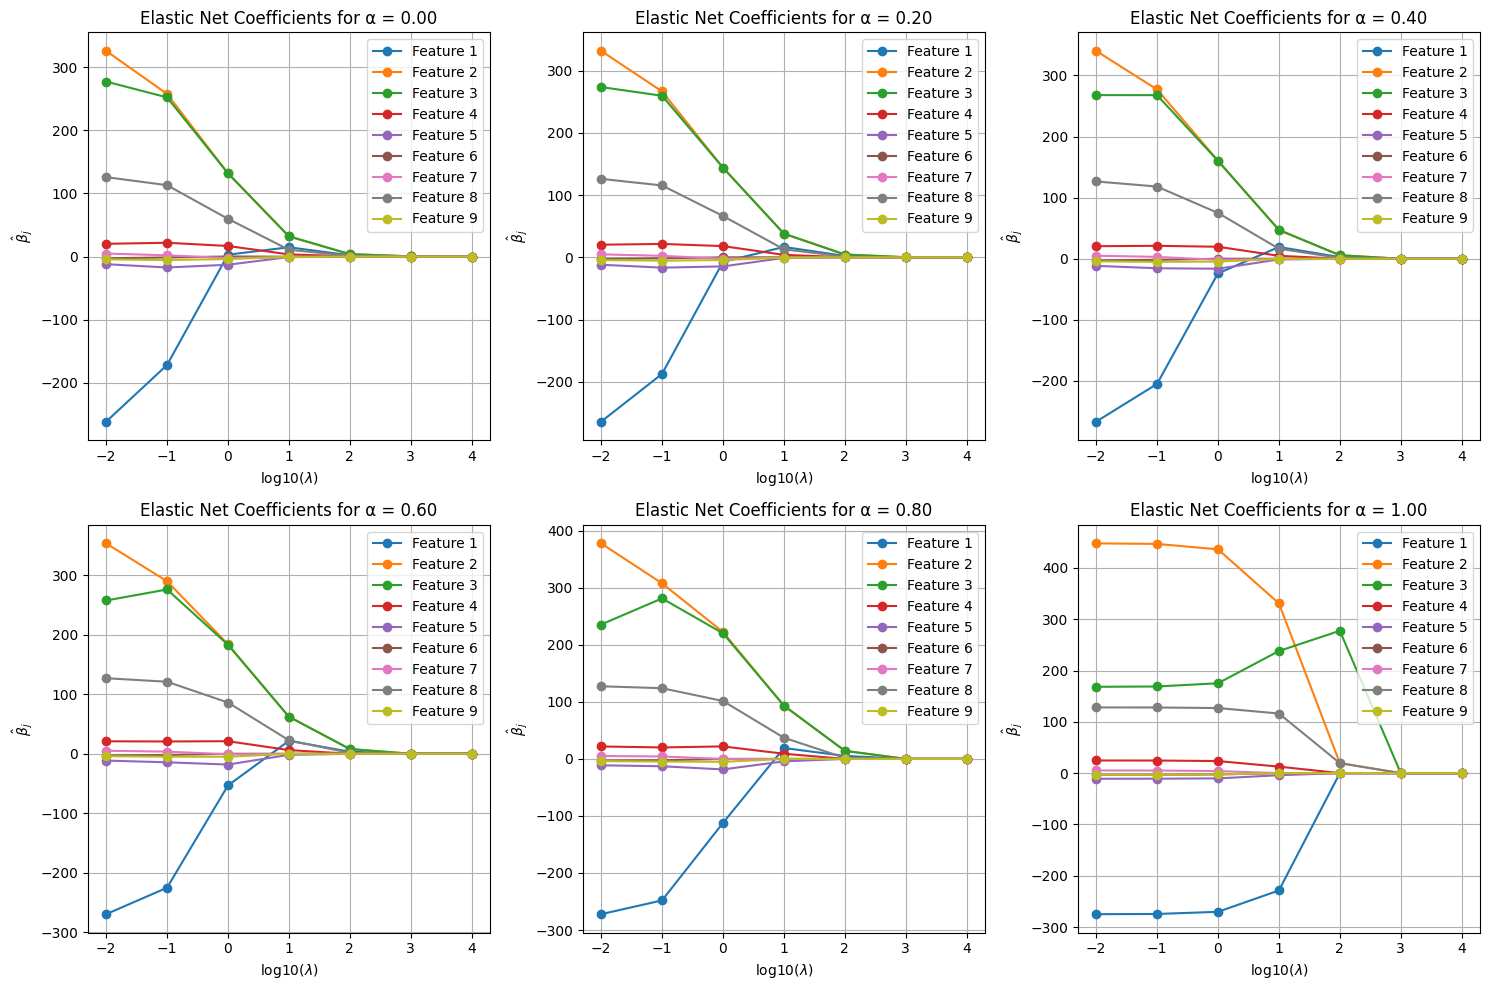

In [ ]:
# Deliverable 1 with SkLearn

# initialize coefficients array
coefficients = np.zeros((len(alphas), len(lambdas), p))

# find predictions for each combination of alpha and lambda
for i, alpha in enumerate(alphas):
    for j, lambd in enumerate(lambdas):
        model = ElasticNet(alpha=lambd, l1_ratio=alpha, max_iter=1000, tol=1e-6)
        model.fit(X, y)
        coefficients[i, j, :] = model.coef_  # store coefficients

# plotting
plt.figure(figsize=(15, 10))
for i, alpha in enumerate(alphas):
    plt.subplot(2, 3, i + 1)

    for feature_idx in range(p):
        plt.plot(np.log10(lambdas), coefficients[i, :, feature_idx], marker='o', label=f'Feature {feature_idx + 1}')
    plt.title(f'Elastic Net Coefficients for α = {alpha:.2f}')
    plt.xlabel(r'log10($\lambda$)') # raw string for LaTeX printing lambda symbol
    plt.ylabel(r'$\hat{\beta}_j$')
    plt.grid(True)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34418227.507921055, tolerance: 6884.9098
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regulari

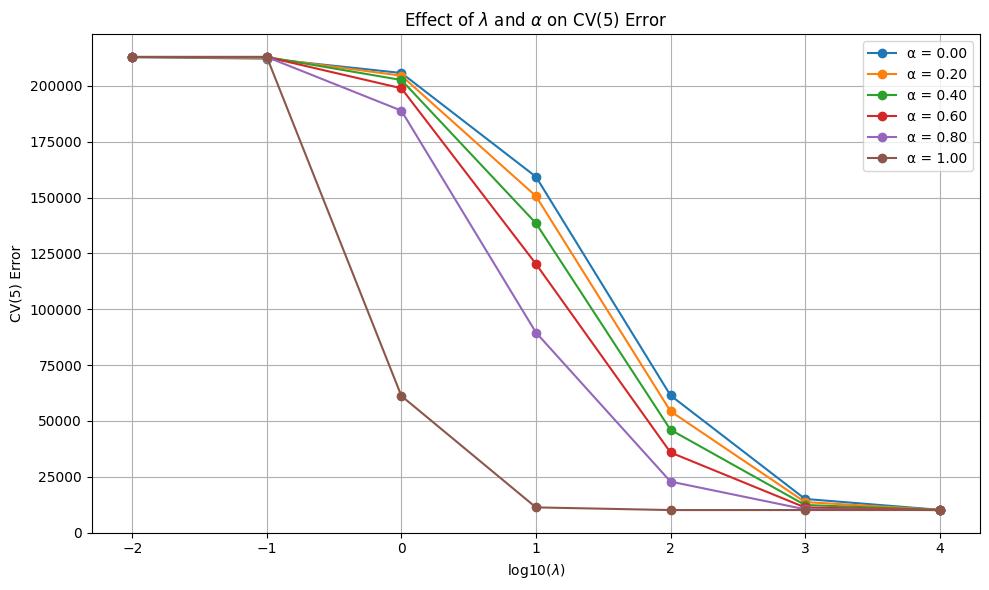

In [ ]:
# Deliverable 2 with SkLearn

# initialize CV error array with 6 rows for alpha and 7 columns for lambda
cv_errors = np.zeros((len(alphas), len(lambdas)))

# find predictions for each combination of alpha and lambda
for i, alpha in enumerate(alphas):
  for j, lambd in enumerate(lambdas):
    model_cv = ElasticNetCV(l1_ratio=alpha, alphas=lambdas, cv=5, max_iter=10000)
    model_cv.fit(X, y)

    # get the mean CV error for each lambda
    mean_cv_errors = model_cv.mse_path_.mean(axis=1)
    cv_errors[i, :] = mean_cv_errors


# plot the results
plt.figure(figsize=(10, 6))
log_lambdas = np.log10(lambdas)  # Log scale for lambda
for i, alpha in enumerate(alphas):
    plt.plot(log_lambdas, cv_errors[i, :], marker='o', label=f'α = {alpha:.2f}')

# plot formatting
plt.xlabel(r'log10($\lambda$)')
plt.ylabel('CV(5) Error')
plt.title(r'Effect of $\lambda$ and $\alpha$ on CV(5) Error')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

# display
plt.show()

In [ ]:
# Deliverable 3 with SkLearn

min_error = float('inf')
best_alpha_index = -1
best_lambda_index = -1

# iterate through  cv_errors matrix to find smallest error value
for i in range(cv_errors.shape[0]):  # row iterations
    for j in range(cv_errors.shape[1]):  # column iterations
        if cv_errors[i, j] < min_error:
            min_error = cv_errors[i, j]
            best_alpha_index = i
            best_lambda_index = j

# extract best alpha and lambda using the indices found
best_alpha = alphas[best_alpha_index]
best_lambda = lambdas[best_lambda_index]

print(f"The smallest CV(5) error is: {np.round(min_error, 4)}")
print(f"Optimal α value is: {best_alpha:.2f}")
print(f"Optimal λ value is: {best_lambda:.2f}")

The smallest CV(5) error is: 10074.2414
Optimal α value is: 0.80
Optimal λ value is: 10000.00


In [ ]:
# Deliverable 4 with SkLearn

#find optimal indices for lasso and ridge
lasso_lambda_ind = np.argmin(cv_errors[0, :])
ridge_lambda_ind = np.argmin(cv_errors[5, :])

# get lambda values at optimal indices
lasso_lambda = lambdas[lasso_lambda_ind]
ridge_lambda = lambdas[ridge_lambda_ind]

# print results
print(f"Optimal Lasso (a=0) Lambda is {lasso_lambda} with error {np.round(cv_errors[0][lasso_lambda_ind], 4)}")
print(f"Optimal Ridge (a=1) Lambda is {ridge_lambda} with error {np.round(cv_errors[5][ridge_lambda_ind], 4)}")

# retrain with optimal alpha and lambda
best_beta = ElasticNet(alpha=best_lambda, l1_ratio=best_alpha, max_iter=1000, tol=1e-6)
best_beta.fit(X, y)
print(f'Predicted Coefficients with Overall Optimal Parameters: \n{list(best_beta.coef_)}\n')

# retrain with lasso regression (a=0)
lasso_beta = ElasticNet(alpha=lasso_lambda, l1_ratio=0, max_iter=1000, tol=1e-6)
lasso_beta.fit(X, y)
print(f'Predicted Coefficients with Lasso Optimal Parameters: \n{list(lasso_beta.coef_)}\n')

# retrain with ridge regression (a=1)
ridge_beta = ElasticNet(alpha=ridge_lambda, l1_ratio=1, max_iter=1000, tol=1e-6)
ridge_beta.fit(X, y)
print(f'Predicted Coefficients with Ridge Optimal Parameters: \n{list(ridge_beta.coef_)}\n')


Optimal Lasso (a=0) Lambda is 10000 with error 10171.4513
Optimal Ridge (a=1) Lambda is 100 with error 10077.2895
Predicted Coefficients with Overall Optimal Parameters: 
[0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0]

Predicted Coefficients with Lasso Optimal Parameters: 
[0.02125534052303319, 0.03950869695552667, 0.03959709166577778, 0.003964393477298785, 8.299139031753517e-05, -0.0003694676051081948, -0.0009846145925071445, 0.011877601424477599, -0.0002604129774296357]

Predicted Coefficients with Ridge Optimal Parameters: 
[-0.0, 19.434437674313777, 277.4744791881079, 0.0, -0.0, 0.0, -0.0, 19.51451016182054, -0.0]



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.216e+07, tolerance: 8.434e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


We completed the extra credit assignment using Scikit-Learn's prebuilt ElasticNet function. This function produced convergence warnings stating that the values never fully converged. However, the graphs from deliverable 1 do appear to converge. The smallest CV error from SkLearn's ElasticNet was 10074.2414, which is about 1/20th of our scratch function's 211613.3918. This may indicate that the SkLearn function performed better. As far as the optimal lambda and alpha values found, both models found the optimal lambda to be 10000. However, SkLearn set alpha=0.80, and our function set alpha=1.0. It is also interesting that the SkLearn function produced unsual 0s for the optimal beta coeifficents, perhaps indicating an error in the use of the function. Alternatively, the predicted coefficients may be very small values that have been rounded to 0.0